# Pipeline for the anomaly detection on the SKAB using Isolation Forest (UCL=UPPER CONTROL LIMITS)

In [2]:
# libraries importing
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score
import shap
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from IPython.display import display
from IPython.display import clear_output

import seaborn as sns

import math

# additional modules
import sys
sys.path.append('../utils')
# from evaluating import evaluating_change_point

c:\Users\anastasis\Desktop\DesktopTempChaos\diplomatiki\07misc\testensemble2\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

In [3]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("./data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [4]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

In [5]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (745, 10)

A number of changepoints in the SkAB v1.0: 129

A number of outliers in the SkAB v1.0: 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0
2020-03-01 15:44:07,0.082724,0.132378,1.12118,-0.273216,92.0144,22.2577,221.250,76.9806,0.0,0.0
2020-03-01 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0.0,0.0
2020-03-01 15:44:09,0.083335,0.132742,1.25962,-0.273216,92.2438,22.2657,230.375,77.0000,0.0,0.0
2020-03-01 15:44:10,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0.0,0.0


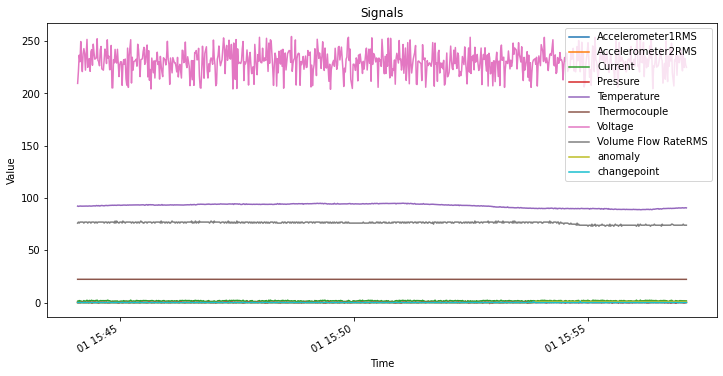

In [6]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

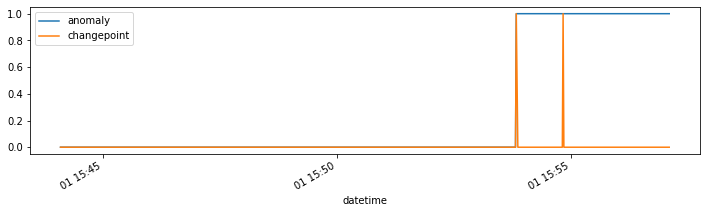

In [7]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [8]:
def plot_confusion_matrix(df, y_actual, y_predicted):
    px = 1/plt.rcParams['figure.dpi']

    fig = plt.figure()
    fig.patch.set_facecolor((1,1,1,1))
    fig.patch.set_alpha(1.0)


    confusion_matrix = pd.crosstab(df[y_actual], df[y_predicted], rownames=['Actual'], colnames=['Predicted'])
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='g')
    
    plt.title(y_predicted.replace("anomaly_by_",""))
    plt.show()

In [9]:
def get_x_y(n):
   x = -1
   y = -1
   if int(math.sqrt(n)) == math.sqrt(n):
      x = int(math.sqrt(n))+1
      y = int(math.sqrt(n))+1
      return x, y
   
   m = n
   while int(math.sqrt(m)) == math.sqrt(m):
      m-=1

   x = int(math.sqrt(m))+1
   y = int(math.sqrt(m))+1
   return x, y

In [10]:
def plot_confusion_matrix_all(df, y_actual, xxx, cont, *cols):
  px = 1/plt.rcParams['figure.dpi']

  fig = plt.figure(figsize=(1920*px, 1080*px))
  # fig = plt.figure(figsize = (24,8))
  fig.patch.set_facecolor((1,1,1,1))
  fig.patch.set_alpha(1.0)
  
  x, y = get_x_y(len(cols))

  
  fig.subplots_adjust(hspace=0.5, wspace=0.5)

  for i,col in enumerate(cols):
    ax = fig.add_subplot(x, y, i+1)

    roc_number = roc_auc_score(df[y_actual], df[col])

    model_title = col.replace("anomaly_by_","")
    F1 = f1_score(df[y_actual], df[col])
    custom_title = f"{xxx} - {cont}\n{model_title}\nAUC: {roc_number}\n{F1}"
    confusion_matrix = pd.crosstab(df[y_actual], df[col], rownames=['Actual'], colnames=['Predicted'])
    g = sns.heatmap(confusion_matrix, annot=True, fmt='g', ax = ax).set_title(custom_title)
  plt.show()

N_ESTIMATORS: 100 and CONTAMINATION: 0.001


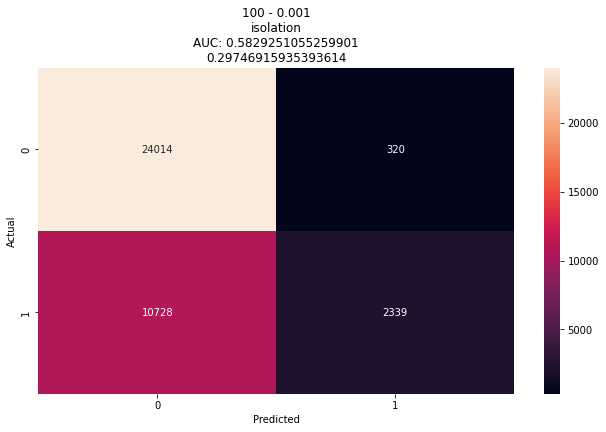

N_ESTIMATORS: 1000 and CONTAMINATION: 0.001


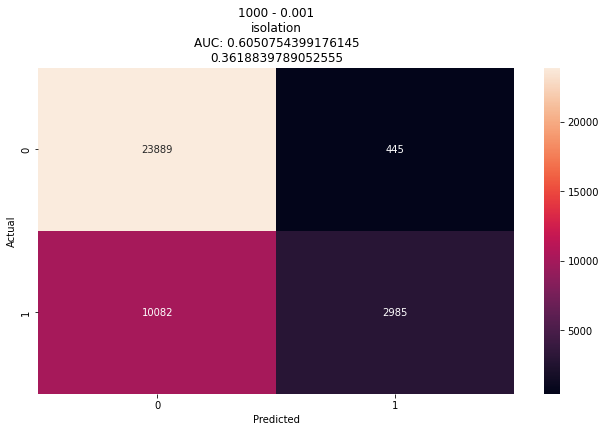

N_ESTIMATORS: 100 and CONTAMINATION: 0.005


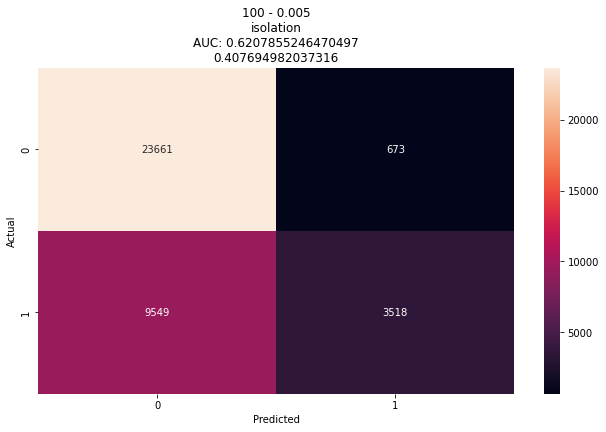

N_ESTIMATORS: 1000 and CONTAMINATION: 0.005


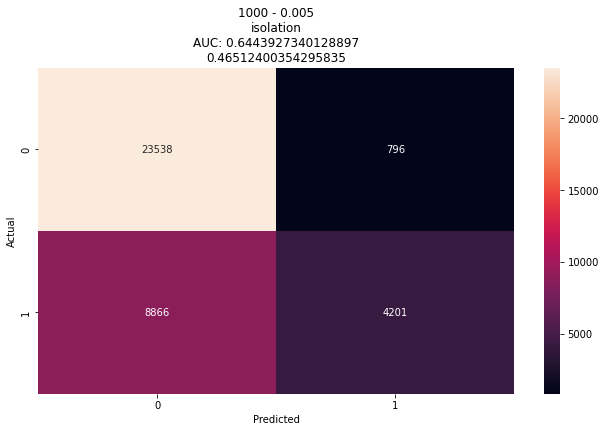

N_ESTIMATORS: 100 and CONTAMINATION: 0.01


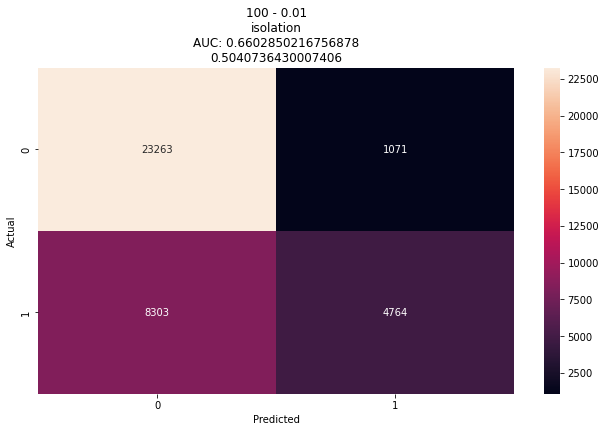

N_ESTIMATORS: 1000 and CONTAMINATION: 0.01


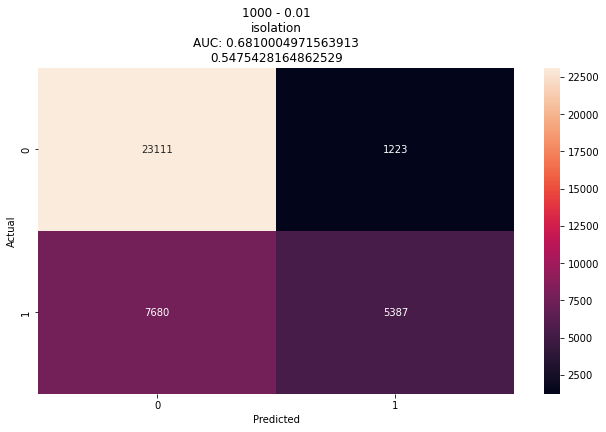

N_ESTIMATORS: 100 and CONTAMINATION: 0.015


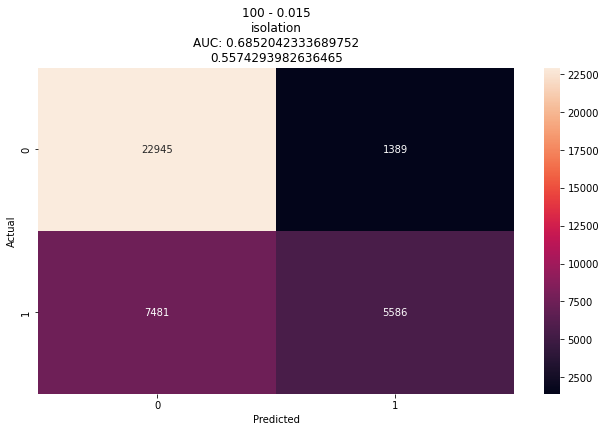

N_ESTIMATORS: 1000 and CONTAMINATION: 0.015


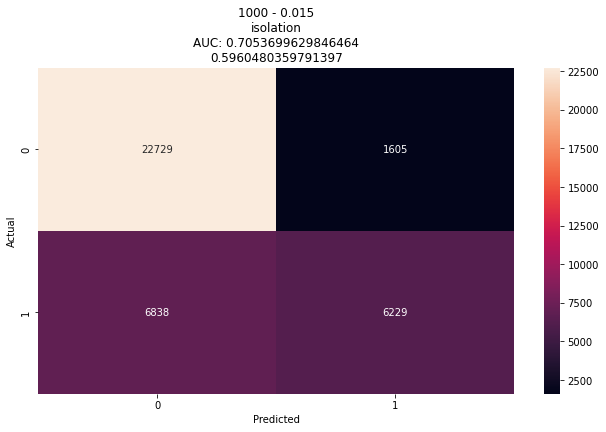

N_ESTIMATORS: 100 and CONTAMINATION: 0.1


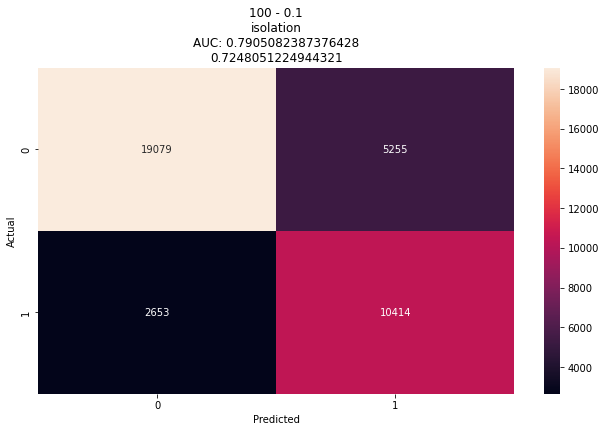

N_ESTIMATORS: 1000 and CONTAMINATION: 0.1


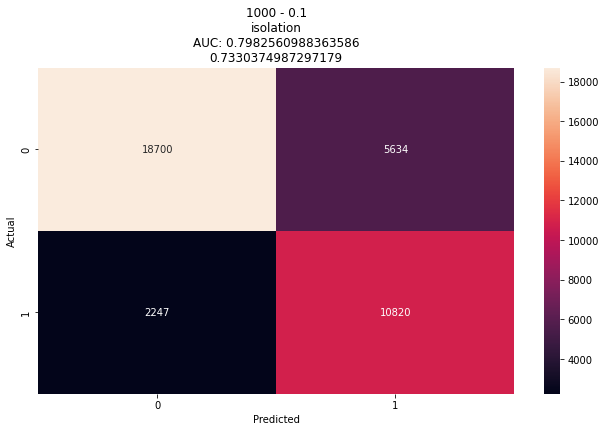

N_ESTIMATORS: 100 and CONTAMINATION: 0.15


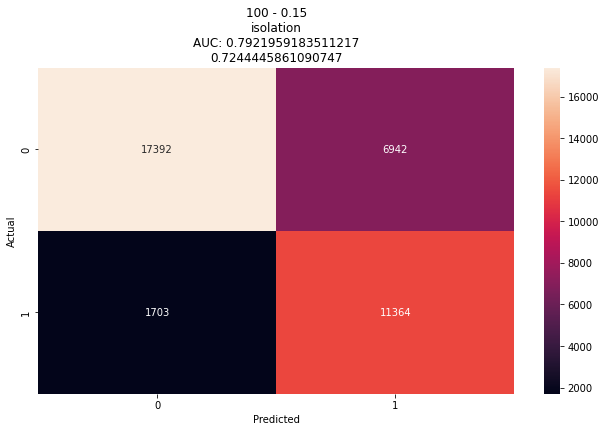

N_ESTIMATORS: 1000 and CONTAMINATION: 0.15


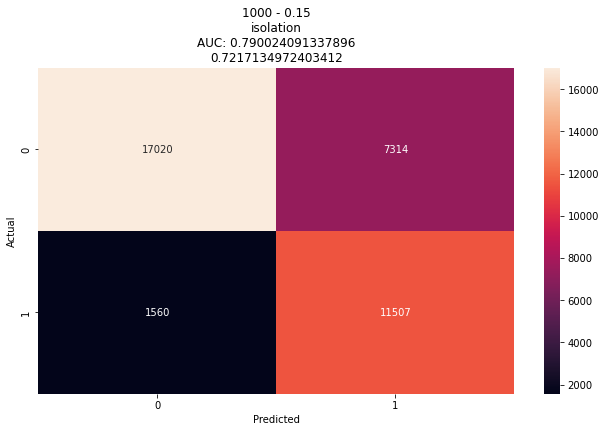

N_ESTIMATORS: 100 and CONTAMINATION: 0.2


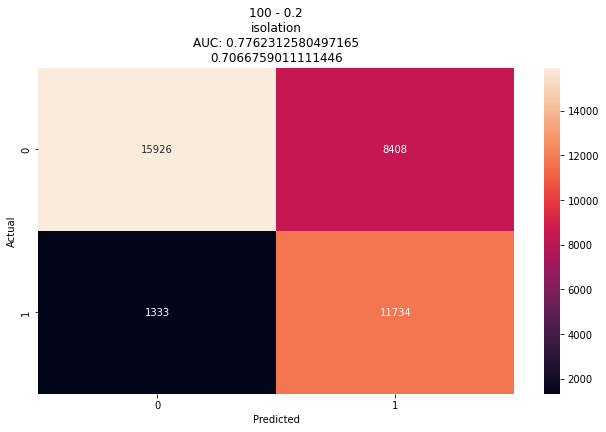

N_ESTIMATORS: 1000 and CONTAMINATION: 0.2


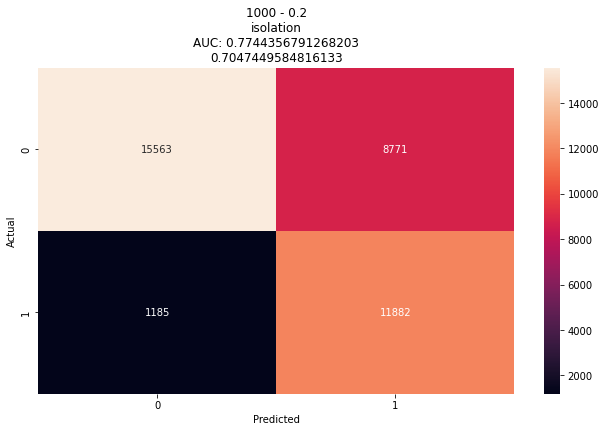

N_ESTIMATORS: 100 and CONTAMINATION: 0.3


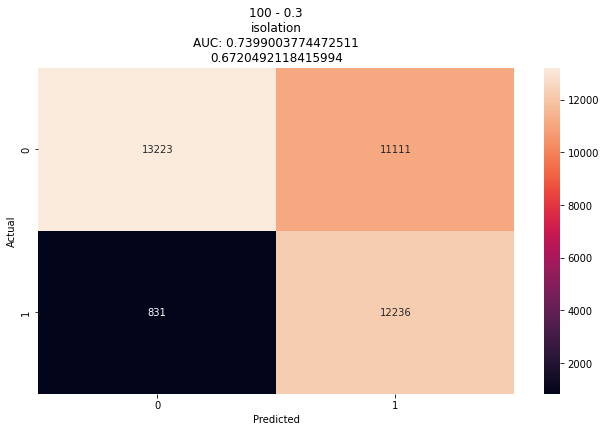

N_ESTIMATORS: 1000 and CONTAMINATION: 0.3


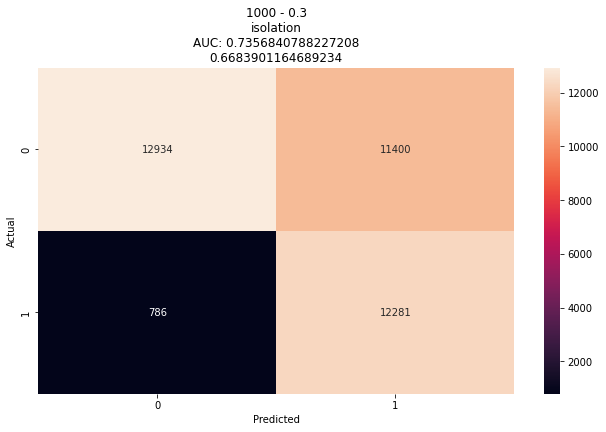

In [12]:
for cont in [0.001, 0.005,0.01, 0.015, 0.1, 0.15, 0.2, 0.3]:
    for x in [100,1000]:
        print(f"N_ESTIMATORS: {x} and CONTAMINATION: {cont}")
        # inference
        # classifier initializing
        clf = IsolationForest(n_estimators=x,
                            random_state=0, 
                            n_jobs=-1,
                            contamination=cont)
        predicted_outlier, predicted_cp = [], []
        final_aggr_pd = None
        count_progress = 0
        for df in list_of_df:
            count_progress+=1
            X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
            
            # classifier fitting
            clf.fit(X_train.values)
            
            # results predicting
            prediction_iso_0 = pd.DataFrame(pd.Series(clf.predict(df.drop(['anomaly','changepoint'], axis=1).values), index=df.index))
            prediction_iso_0 = prediction_iso_0.rename(columns={0:"anomaly_by_isolation"})
            prediction_iso_0["anomaly_by_isolation"] = prediction_iso_0["anomaly_by_isolation"].apply(lambda x: 1 if (x == -1) else 0 )
            
            
            # actual_use = -1
            # previous_vals = (9999,9999)

            # min_sum = 9999+9999
            # min_sum_ind = -1
            # for i in range(3,70):
            #     prediction_iso2 = prediction_iso_0.rolling(i)
            #     prediction_iso3 = prediction_iso2.median()
            #     prediction_iso4 = prediction_iso3.fillna(0)
            #     prediction_iso = prediction_iso4.replace(-1,0)
            

            #     # prediction_iso = prediction_iso.rename(columns={0:"anomaly_by_isolation"})

            #     prediction_isolation = pd.DataFrame(pd.Series(data=df.anomaly.astype(int), index=df.index))
            #     prediction_isolation = prediction_isolation.join(prediction_iso)
            #     prediction_isolation["anomaly_by_isolation"] = np.where(prediction_isolation['anomaly_by_isolation'] <= 0 , 0, 1)
            #     actual_0_pred_1_want_0 = prediction_isolation[(prediction_isolation["anomaly"]==0)&(prediction_isolation["anomaly_by_isolation"]==1)]["anomaly"].count()
            #     actual_1_pred_0_want_0 = prediction_isolation[(prediction_isolation["anomaly_by_isolation"]==0)&(prediction_isolation["anomaly"]==1)]["anomaly"].count()
            #     current_sum = actual_0_pred_1_want_0+actual_1_pred_0_want_0
            #     if ((actual_0_pred_1_want_0 < previous_vals[0]) and (actual_1_pred_0_want_0 <= previous_vals[1]))\
            #         or ((actual_0_pred_1_want_0 <= previous_vals[0]) and (actual_1_pred_0_want_0 < previous_vals[1])):
            #         actual_use = i
            #         previous_vals = (actual_0_pred_1_want_0,actual_1_pred_0_want_0)
                
            #     if current_sum<min_sum:
            #         min_sum = current_sum
            #         min_sum_ind = i

            # print(f"BEST actual_use: {actual_use}")
            # print(f"BEST previous_vals: {previous_vals}")

            # print(f"BEST min_sum_ind: {min_sum_ind}")
            # print(f"BEST min_sum: {min_sum}")
            
            prediction_iso2 = prediction_iso_0.rolling(3)
            prediction_iso3 = prediction_iso2.median()
            prediction_iso4 = prediction_iso3.fillna(0)
            prediction_iso = prediction_iso4.replace(-1,0)


            # prediction_iso = prediction_iso.rename(columns={0:"anomaly_by_isolation"})

            prediction_isolation = pd.DataFrame(pd.Series(data=df.anomaly.astype(int), index=df.index))
            prediction_isolation = prediction_isolation.join(prediction_iso)
            prediction_isolation["anomaly_by_isolation"] = np.where(prediction_isolation['anomaly_by_isolation'] <= 0 , 0, 1)
            
            cols = ["anomaly_by_isolation"]

            # plot_confusion_matrix_all(prediction_isolation, "anomaly", *cols)

            final_aggr_pd = pd.concat([final_aggr_pd, prediction_isolation], ignore_index=True)

            # prediction_iso2 = prediction_iso_0.rolling(min_sum_ind)
            # prediction_iso3 = prediction_iso2.median()
            # prediction_iso4 = prediction_iso3.fillna(0)
            # prediction_iso = prediction_iso4.replace(-1,0)


            # # prediction_iso = prediction_iso.rename(columns={0:"anomaly_by_isolation"})

            # prediction_isolation = pd.DataFrame(pd.Series(data=df.anomaly.astype(int), index=df.index))
            # prediction_isolation = prediction_isolation.join(prediction_iso)
            # prediction_isolation["anomaly_by_isolation"] = np.where(prediction_isolation['anomaly_by_isolation'] <= 0 , 0, 1)
            
            # cols = ["anomaly_by_isolation"]

            # plot_confusion_matrix_all(prediction_isolation, "anomaly", *cols)
            
            # # predicted outliers saving
            # predicted_outlier.append(prediction)
            
            # # predicted CPs saving    
            # prediction_cp = abs(prediction.diff())
            # prediction_cp[0] = prediction[0]
            # predicted_cp.append(prediction_cp)

        cols = ["anomaly_by_isolation"]
        plot_confusion_matrix_all(final_aggr_pd, "anomaly", x, cont, *cols)

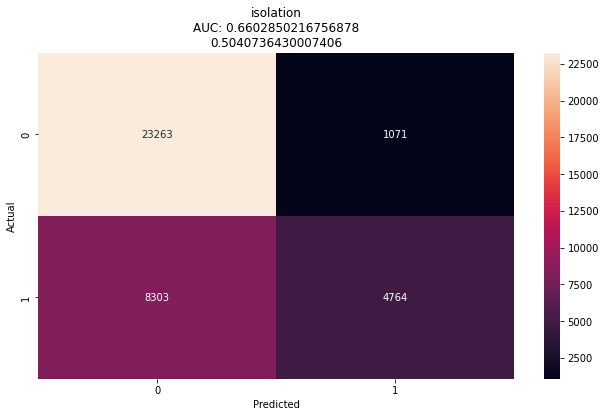

In [ ]:
cols = ["anomaly_by_isolation"]
plot_confusion_matrix_all(final_aggr_pd, "anomaly", *cols)

In [25]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

IndexError: list index out of range

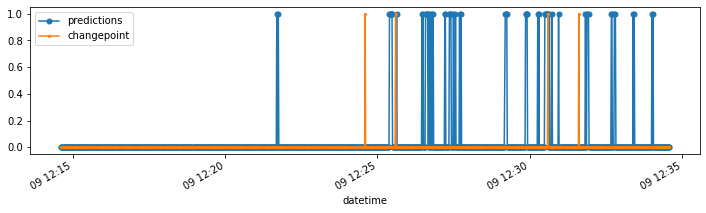

In [ ]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [11]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 6.86 %
Missing Alarm Rate 72.09 %
F1 metric 0.4


In [12]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:08.821917808
A number of missed CPs = 57


In [13]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 27
Intersec

## [Additional] localization

Shap repository with explonations [link](https://github.com/slundberg/shap)

In [18]:
# load JS visualization code to notebook
# shap.initjs()

In [19]:
# Create shap values and plot them
# X_explain = list_of_df[0][:'2019-07-08 18:30']#[pd.Series(prediction, index=data.index)==-1]

# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_explain)

# shap.summary_plot(shap_values, X_explain, plot_type='bar')

In [20]:
# Create shap values and plot them
# X_explain = data['2019-07-08 18:30':'2019-07-08 18:50']#[pd.Series(prediction, index=data.index)==-1]

# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_explain)

# shap.summary_plot(shap_values, X_explain, plot_type='bar')

In [21]:
# shap.force_plot(explainer.expected_value, shap_values, X_explain)